### Belgian Traffic signs classification with CNN
This dataset is very messy because the images have different sizes and the number of signs in each class is not equal. Also, there are a lot of low quality of images which makes predictions harder! and finally, There are 62 classes. In this notebook, I did as follow:
1. Load data
2. Resize and change RGB images to grayscale images
3. Convert labels to one-hot vector
4. Split test data into two part: Validation set and test set.
4. Generate mini-batches
5. Define hyperparameters
6. Define Tensorflow graph:
   1. Initial placeholders for inputs
   2. Define Convolution layers
   3. Define fully connected layers
   4. Compute softmax  and predict the labels
   5. Compute cost and optimize it with Adam optimizer
   6. Predict labels on validation set and calculate accuracy
7. Start sensor flow Session
   1. Loop over number of epochs
      1. Initial epoch variables ( epoch cost, best accuracy...)
      2. Loop over number of mini-batches
         1. Run Cost and Optimizer in Tensorflow graph
         2. Add current mini batch cost to epoch cost
      3. Run accuracy from graph, and calculate validation cost and accuracy over validation set 
      4. print out results for current epoch
8. See what was classified wrongly!


In [1]:
import numpy as np
import tensorflow as tf
import os
import time
from skimage import data
from skimage import transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

##### 1. Load data
The signs in training folder and test folder are classified by their respective folder. All signs for first class are in folder 000001 and so on.

In [2]:
# import training data
def load_data(data_path):
    directories = [d for d in os.listdir(data_path)
                   if os.path.isdir(os.path.join(data_path, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_path,d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(data.imread(f))
            labels.append(int(d))
    return images, labels

# ROOT_PATH = "/home/alireza/ai/trafficSigns"

# training data
# train_data_dir = os.path.join(ROOT_PATH, "data/Training")
train_data_dir = "data/Training"
images_tr, labels_tr = load_data(train_data_dir)

# test Data
# test_data_dir = os.path.join(ROOT_PATH, "data/Testing")
test_data_dir = "data/Testing"
images_ts, labels_ts = load_data(test_data_dir)

Here we can see a histogram of width and height of images. The images have variety of sizes

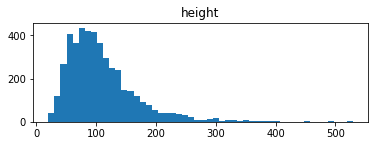

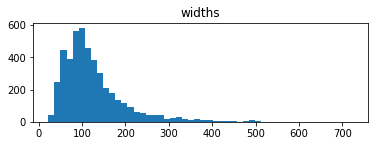

In [3]:
# get average of training images size and resize all images
m = len(images_tr)
widths = [i.shape[0] for i in images_tr]
heights = [i.shape[1] for i in images_tr]
plt.subplot(2,1,1)
plt.hist(heights,bins=50)
plt.title("height")
plt.show()

plt.subplot(2,1,2)
plt.hist(widths,bins=50)
plt.title("widths")
plt.show()


In [4]:
print("average widths: {0}, average heights:{1}".format(int(np.mean(widths)), int(np.mean(heights))))

average widths: 124, average heights:109


##### .2 Resize and change images to grayscale
according to the above-calculated averages, 96 or even 128 is a good choice. In total, when I used the bigger size, I got better results by appx. 1%. It is also possible to get almost 96% accuracy with 32 by 32 pixels.
Also by changing images to grayscale images, we save a lot of computation because the effect of colors (RGB) is less than 0.5% on accuracy. Does it worth?

In [5]:
# resize all images to 'image_size' variable.
image_size = 64
images_tr = [transform.resize(i, (image_size,image_size)) for i in images_tr]
images_ts = [transform.resize(i, (image_size,image_size)) for i in images_ts]

# change to grayscale
# the final output prediction is less than 0.5% on rgb signs
images_tr = [rgb2gray(image) for image in images_tr]
images_ts = [rgb2gray(image) for image in images_ts]


/home/alireza/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(64, 64)


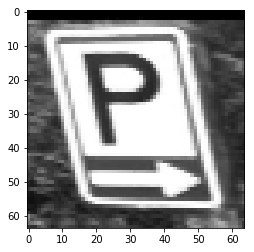

In [6]:
# show what we have done :)
print(images_tr[4].shape)
plt.imshow(images_tr[4], cmap=plt.cm.gray)
plt.show()

##### 3. Convert labels to one-hot vectors
To use **softmax cross entrophy with logtits** function in tensorflow, we need to convert labels into one-hot vectors. 

In [7]:
# convert labels to np.array
# channel = 3
num_classes = len(set(labels_tr))
labels_tr = np.array(labels_tr)
labels_ts = np.array(labels_ts)

# convert labels to one_hot array
labels_one_hot_tr = np.zeros([labels_tr.size, labels_tr.max()+1])
labels_one_hot_tr[np.arange(labels_tr.size), labels_tr] = 1

labels_one_hot_ts = np.zeros([labels_ts.size, labels_ts.max()+1])
labels_one_hot_ts[np.arange(labels_ts.size), labels_ts] = 1

##### 4. Split test data into two part: Validation set and test set.
When I wanted to use whole test set, I got a __OOM__ error by tensorflow, because it was not possible to put the whole test set in my graphic card memory. so I decided to divide it into two parts ( somehow useless!). I appreciate for your better solution :)

In [8]:
# Divide test data to two data set, dev set, and test set 50:50
m = labels_one_hot_ts.shape[0]
per = np.arange(m)
np.random.shuffle(per)
# convert images data to np.array
images_np = np.array(images_ts)
images_shuffle = images_np[per]
labels_shuffle = labels_one_hot_ts[per]
half = int(m/2)
# first half for devset
devset_img = images_shuffle[0:half]
devset_lbl = labels_shuffle[0:half]
# second half for testset
testset_img = images_shuffle[half:m]
testset_lbl = labels_shuffle[half:m]

# # use all test data for validation set
# devset_img = np.array(images_ts)
# devset_lbl = labels_one_hot_ts

##### 5. Generate mini-batches
For each epoch, we shuffle images and return new mini-batch series.

In [9]:
# data and labels should be a numpy array
def mini_batch_generator(x,y, mini_batch_size):
    assert x.shape[0]==y.shape[0]
    
    m = y.shape[0]
    
    # shuffle data
    idx = np.random.permutation(m)
    x = x[idx]
    y = y[idx]
    
    num_mini_batches = int(m/mini_batch_size)
    mini_batches = []
    for i in range(num_mini_batches):
        p = i*mini_batch_size
        x_mini_batch = x[p : p + mini_batch_size]
        y_mini_batch = y[p : p + mini_batch_size]
        mini_batch = (x_mini_batch, y_mini_batch)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [10]:
images_np = np.array(images_tr)
mini_batch_size = 32
mb = mini_batch_generator(images_np, labels_one_hot_tr, mini_batch_size)

##### 6. Define hyperparameters
the current model is very complex and can learn training signs very good. Becuase the training cost goes to approx. 0.1. The validation cost is also approx. 0.8. therefor I choose a dropout of 0.5 which force the model to lean more general features and prevent it to overfit the training data. [need more comment]

In [11]:
# model parameters
fc_layers = 3
filter_size = 5
num_filters = [32, 32 , 32, 64, 64, 128]
hidden_size = 2048
lr = 0.001
num_epochs = 100
lr_decay = 0.95
dropout= 0.5

#### 7. Define Tensorflow graph:
##### 7.1. Initial placeholders for inputs

In [12]:
# define placeholders for input parameters
X = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size], name="X")
X_expand = tf.expand_dims(X, -1)

Y = tf.placeholder(dtype=tf.float32, shape=[None,num_classes], name="Y")
keep_prob = tf.Variable(0.5, dtype=tf.float32, name="dropout", trainable=False)
learning_rate = tf.Variable(0.001, dtype=tf.float32, name='learning_rate', trainable=False)

In [13]:
# convert Y one hot to Y classification array
y_true_cls = tf.argmax(Y,1)

##### 7.2 Define Convolution layers

In [14]:
# If we use gray scale images, we have only one channel, so we should later expand the dimension of input image to
# [batch_size, height, width, in_channel] and here in_channel = 1
# otherwise, if the images are RGB, we don't need to expand it
inputs = X_expand
# inputs = X
for i in range(len(num_filters)):
    net = tf.layers.conv2d(inputs=inputs,
                           name="conv_layer{0}".format(i),
                           padding = 'same',
                           filters = num_filters[i],
                           kernel_size = filter_size,
                           activation = tf.nn.relu)
    
    # perform max pooling only on odd layer!
    if i%2 == 1:
        inputs = tf.layers.max_pooling2d(inputs=inputs, pool_size=2, strides=2)
        # it is good to know, what going on here :)
        print("layer {} pooling: {}".format(i, inputs.get_shape()))
    else:
        inputs = net
        # it is good to know, what going on here :)
        print("layer {} conv2d: {}".format(i, inputs.get_shape()))
    
# convert final out from convolution to 2D shape
flatted_inputs = tf.contrib.layers.flatten(inputs)
# Use dropout
dropped_inputs = tf.nn.dropout(flatted_inputs, keep_prob=keep_prob)
# show what is the dimension of flatted layer
print(flatted_inputs.get_shape())

fc_layer = dropped_inputs
# 7.3 Define fully connected layers 
for i in range(fc_layers):
    fc_layer = tf.contrib.layers.fully_connected(fc_layer,num_outputs=hidden_size, activation_fn=tf.nn.relu)
    # we should prevent dropout for logits. So last layer don't need dropout
    if i != fc_layers-1:
        fc_layer = tf.nn.dropout(fc_layer, keep_prob=keep_prob)
        hidden_size = int(hidden_size/2)
    
# 7.4 Calculate logits
logits = tf.contrib.layers.fully_connected(fc_layer, num_outputs=num_classes, activation_fn=None)
cross_entopy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y)

layer 0 conv2d: (?, 64, 64, 32)
layer 1 pooling: (?, 32, 32, 32)
layer 2 conv2d: (?, 32, 32, 32)
layer 3 pooling: (?, 16, 16, 32)
layer 4 conv2d: (?, 16, 16, 64)
layer 5 pooling: (?, 8, 8, 64)
(?, 4096)


##### 7.5 Calculate cost and optimize it

In [15]:
# define cost function
cost = tf.reduce_mean(cross_entopy)
# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

##### 7.6 predict labels and calculate accuracy

In [16]:
# predict labels
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred,1)

In [17]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
# define a directory to save best model
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'best_validation')


#### 8. Start sensor flow Session

In [19]:
# initial a session and start learning with the graph
init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    # initial a saver object
    saver = tf.train.Saver()

    train_loses = []        # store train loses 
    validation_loses = []   # store validation loses
    best_acc = 0.
    tic = time.time()
    for e in range(num_epochs):
        # 8.1- Initial epoch variables
        epoch_cost = 0.

        # 8.2- loop over all mini-batches
        for batch in mb:
            
            x_batch, y_batch = batch
            
            # 8.2.1- Run Cost and Optimizer in Tensorflow graph
            batch_los, _ = sess.run([cost, optimizer], feed_dict={X:x_batch, Y:y_batch, keep_prob:dropout, learning_rate:lr})
            # 8.2.2- Add current mini batch cost to epoch cost
            epoch_cost += batch_los

        # 8.3- Run accuracy from graph, and calculate validation cost and accuracy over validation set
        # Becareful! we should NOT use dropout here, actually set dropout=1.0
        val_los, acc = sess.run([cost, accuracy], feed_dict={X:devset_img, Y:devset_lbl, keep_prob:1.0})
        # 8.4- Print the result of epoch
        print("epoch {0:>3}: train cost: {1:>6.4f}, validation cost: {2:>6.4f}, Validation accuracy:{3:>6.2%}".format(e + 1, epoch_cost, val_los, acc))

        # update learning rate
        lr = lr * lr_decay
        # save best model:
        if acc > best_acc:
#             print("new record:{0:.2%}, old record:{0:.2%}".format(acc, best_acc))
            saver.save(sess=sess, save_path=save_path)
            best_acc = acc
        # save epoch cost and validation cost to plot later
        train_loses.append(epoch_cost)
        validation_loses.append(val_los)
    toc = time.time()
    print("training time: {} seconds".format(int(toc-tic)))


epoch   1: train cost: 439.7799, validation cost: 1.8009, Validation accuracy:50.87%
epoch   2: train cost: 193.3767, validation cost: 1.1545, Validation accuracy:68.97%
epoch   3: train cost: 111.4936, validation cost: 0.5445, Validation accuracy:85.00%
epoch   4: train cost: 70.3771, validation cost: 0.3577, Validation accuracy:89.84%
epoch   5: train cost: 51.4566, validation cost: 0.2384, Validation accuracy:93.73%
epoch   6: train cost: 37.6362, validation cost: 0.1958, Validation accuracy:93.97%
epoch   7: train cost: 28.4718, validation cost: 0.2021, Validation accuracy:94.68%
epoch   8: train cost: 23.5063, validation cost: 0.2014, Validation accuracy:93.97%
epoch   9: train cost: 17.1934, validation cost: 0.1488, Validation accuracy:96.19%
epoch  10: train cost: 13.8169, validation cost: 0.1340, Validation accuracy:96.59%
epoch  11: train cost: 10.7615, validation cost: 0.1524, Validation accuracy:96.03%
epoch  12: train cost: 12.4086, validation cost: 0.1568, Validation accur

epoch 100: train cost: 0.4554, validation cost: 0.1325, Validation accuracy:98.02%
training time: 168 seconds


plot the train cost and validation cost over the epochs

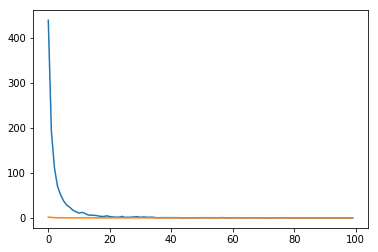

In [20]:
plt.plot(train_loses)
plt.plot(validation_loses)
plt.show()

#### 8.See what was classified wrongly!
To do this, first, we load the best model, and again predict labels on the test and then get the items which predicted false. Then show __test image__ with the __predicted image__.

In [21]:
#
with tf.Session() as sess:
    # Initial saver object
    saver = tf.train.Saver()
    
    # check if it is exsit!
    if os.path.exists(save_dir):
        # restore weights and biases
        saver.restore(sess=sess, save_path=save_path)
        # calculate 
        pred_results, pred_cls, true_cls, acc, test_los  = sess.run([correct_prediction,y_pred_cls, y_true_cls, accuracy, cost], feed_dict={X:testset_img, Y:testset_lbl, keep_prob:1.0})
        saver.save(sess=sess, save_path=save_path)
        print("test cost: {0:>4.4f}, accuracy: {1:>4.2%}".format(test_los, acc))

INFO:tensorflow:Restoring parameters from checkpoints/best_validation
test cost: 0.3303, accuracy: 96.75%


Show 16 false classified images. the odd rows are test images, and the even rows are corresponding predicted images (label)

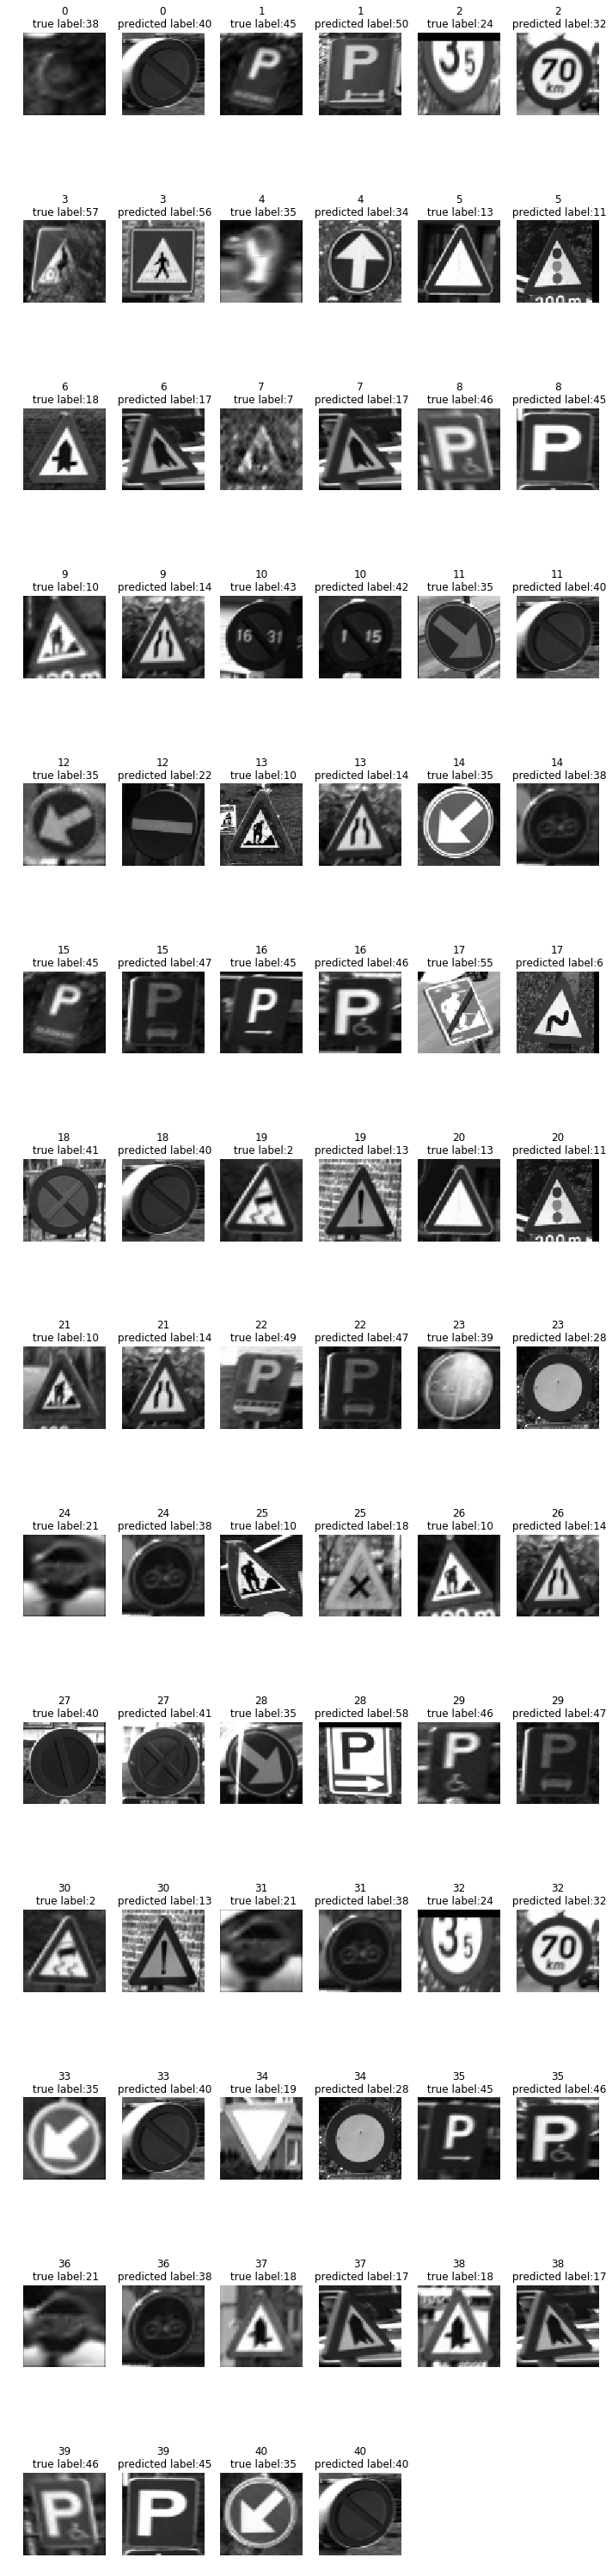

In [22]:
# show false answers
incorrect = (pred_results==False)
images = testset_img[incorrect]
false_predict = pred_cls[incorrect]
true_labels = true_cls[incorrect]
true_list = labels_tr.tolist()
assert len(images)==len(false_predict)
m = len(images)
plt.figure(figsize=(12,4*m))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
counter = 1

for i in range(m):
    plt.subplot(m,6, counter)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.title("{}\n true label:{}".format(i, true_labels[i]))
    plt.axis('off')
    
    plt.subplot(m,6,counter+1)
    plt.imshow(images_tr[true_list.index(false_predict[i])], cmap=plt.cm.gray)
    plt.title("{}\n predicted label:{}".format(i, false_predict[i]))
    plt.axis('off')
    counter +=2
plt.show()
np.set_printoptions(threshold=np.inf)



Next, I want to do some feature engineering on images such as sobel filter... so stay tuned